In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score

In [8]:
match_data = pd.read_csv("data/role_data.csv")

In [9]:
match_data.columns

Index(['top_vs', 'top_mastery', 'side', 'first_brick', 'first_blood',
       'first_dragon', 'first_herald', 'first_baron', 'first_inhib',
       'num_towers', 'num_dragons', 'num_barons', 'num_inhibs', 'result',
       'jungle_vs', 'jungle_mastery', 'mid_vs', 'mid_mastery', 'adc_vs',
       'adc_mastery', 'sup_vs', 'sup_mastery'],
      dtype='object')

### Feature Time

Let's first decide which features not to include for this analysis. We're not going to include numbers of inhibs, towers, dragons, or barons as these reflect late game state. In particular, one cannot destroy the nexus without taking 5 towers and one inhib, so this is not good to use predictively. Further we're not going to use first baron and first inhib for similar reasons.

In [10]:
X_feat = ['top_vs', 'top_mastery', 'first_brick', 'first_blood',
       'first_dragon', 'first_herald',
       'jungle_vs', 'jungle_mastery', 'mid_vs', 'mid_mastery', 'adc_vs',
       'adc_mastery', 'sup_vs', 'sup_mastery']
y_feat = ['result']

### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(match_data[X_feat],match_data[y_feat],train_size=.8, random_state=262)

### Let's Try Some Models

We're going to try random forests, logistic regression, and naive bayes with default parameters (sometimes explicitly stated to suppress a warning), then tune hyperparameters on the winner. With more time, we could do hyperparameters on each model before chosing which one. We're going to look at accuracy, precision, recall, f1 score, and roc_auc as our metrics.

In [12]:
scoring = ["accuracy","precision","recall","f1","roc_auc"]

In [13]:
rfc_model = RandomForestClassifier(n_estimators=100)

rfc_scores = cross_validate(rfc_model,X_train,y_train.to_numpy().ravel(),cv=10,scoring=scoring)

In [14]:
for key, val in zip(rfc_scores.keys(),rfc_scores.values()):
    print(key,np.mean(val))

fit_time 0.5195828676223755
score_time 0.11547484397888183
test_accuracy 0.7107204953076511
test_precision 0.6870562721683096
test_recall 0.7044117647058824
test_f1 0.6939256502717985
test_roc_auc 0.7735413234214245


In [15]:
lr_model = LogisticRegression(solver="lbfgs")

lr_scores = cross_validate(lr_model,X_train,y_train.to_numpy().ravel(),cv=10,scoring=scoring)

In [16]:
for key, val in zip(lr_scores.keys(),lr_scores.values()):
    print(key,np.mean(val))

fit_time 0.032644462585449216
score_time 0.030062341690063478
test_accuracy 0.46958170848079106
test_precision 0.4390224676403297
test_recall 0.5540346907993967
test_f1 0.48628816657762197
test_roc_auc 0.45998661839415445


In [17]:
nb_model = GaussianNB()

nb_scores =  cross_validate(nb_model,X_train,y_train.to_numpy().ravel(),cv=10,scoring=scoring)

In [18]:
for key, val in zip(nb_scores.keys(),nb_scores.values()):
    print(key,np.mean(val))

fit_time 0.013073611259460449
score_time 0.02918117046356201
test_accuracy 0.5387408425940536
test_precision 0.4995074189095929
test_recall 0.1858597285067873
test_f1 0.26737478271115017
test_roc_auc 0.5700329603585353


In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_scores = cross_validate(knn_model,X_train,y_train.to_numpy().ravel(),cv=10,scoring=scoring)

In [20]:
for key, val in zip(knn_scores.keys(),knn_scores.values()):
    print(key,np.mean(val))

fit_time 0.012026548385620117
score_time 0.1097498893737793
test_accuracy 0.5305751038778561
test_precision 0.4958050677486431
test_recall 0.4559200603318251
test_f1 0.47319452636745557
test_roc_auc 0.5357565676092854


### Random Forest Tuning

So a random forest by far outperformed in all metrics. Let's do a grid search tuning now. 

In [21]:
rfc_param = {"n_estimators":range(100,1000,100),"max_depth":range(1,8)}

rfc_model = RandomForestClassifier()

In [22]:
gs_cv = GridSearchCV(rfc_model, rfc_param, scoring = scoring, refit=False, cv = 5)
gs_cv.fit(X_train,y_train.to_numpy().ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [23]:
gs_cv.cv_results_["mean_test_f1"]

array([0.61631534, 0.61707062, 0.62320096, 0.62006612, 0.61940312,
       0.61780527, 0.61470668, 0.6239193 , 0.62542519, 0.66786034,
       0.67853353, 0.66426715, 0.67020439, 0.66330167, 0.67060552,
       0.67356169, 0.66937374, 0.68053944, 0.68997883, 0.67449935,
       0.69097406, 0.6862681 , 0.68439667, 0.69134912, 0.68293951,
       0.68956408, 0.68546409, 0.69107231, 0.6975782 , 0.69509585,
       0.69516905, 0.69637691, 0.69380776, 0.69850517, 0.69220632,
       0.69499628, 0.70868939, 0.70348897, 0.69533624, 0.69935553,
       0.69761419, 0.70656645, 0.69909902, 0.70909805, 0.7041174 ,
       0.69438986, 0.70432762, 0.70646074, 0.70226215, 0.70508289,
       0.70078377, 0.70290487, 0.70033018, 0.70629409, 0.68343841,
       0.7037058 , 0.70606589, 0.6999345 , 0.6945163 , 0.69782195,
       0.69806137, 0.69860431, 0.69955499])

In [24]:
maximum = 0
max_ind = 0

for i, val in enumerate(gs_cv.cv_results_["mean_test_f1"]):
    if val > maximum:
        max_ind = i
        maximum = val

In [28]:
gs_cv.cv_results_["mean_test_f1"][max_ind]

0.7090980499879317

In [29]:
gs_cv.cv_results_["params"][max_ind]

{'max_depth': 5, 'n_estimators': 800}

So our grid search got an f1 score of $.709$ at max_depth = 5 and n_estimators = 800. Let's keep that for our final model

# Final Model Metrics

In [31]:
final_model = RandomForestClassifier(max_depth=5,n_estimators=800)
final_model.fit(X_train,y_train.to_numpy().ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)

In [33]:
confusion_matrix(y_test, y_pred)

array([[ 98,  46],
       [ 31, 100]])

In [47]:
(98+100)/(98+100+31+46) # accuracy

0.72

In [48]:
100/131#recall

0.7633587786259542

In [49]:
100/(100+46)#precision

0.684931506849315

In [34]:
f1_score(y_test,y_pred)

0.7220216606498194

ROC AUC score =  0.7782018659881256


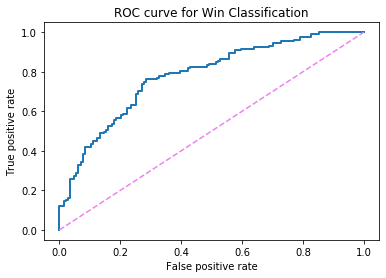

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Win Classification');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_prob[:,1]))

In [36]:
for val in sorted(zip(X_train.columns,final_model.feature_importances_), key = lambda x: x[1], reverse=True):
    print (val)

('first_brick', 0.2186823518212022)
('first_dragon', 0.12809353832724293)
('adc_vs', 0.0825212343131348)
('sup_vs', 0.07835698808933321)
('mid_vs', 0.07727619722211995)
('jungle_vs', 0.06975773824738106)
('mid_mastery', 0.057100548286203714)
('first_herald', 0.053576527575235934)
('top_vs', 0.04935533396329614)
('sup_mastery', 0.04842248296058762)
('adc_mastery', 0.04816709991929931)
('top_mastery', 0.04296798934468598)
('jungle_mastery', 0.04077626642234339)
('first_blood', 0.004945703507933846)


In [37]:
from joblib import dump, load

In [38]:
dump(final_model, "Website/rfc_model.joblib")

['Website/rfc_model.joblib']

In [39]:
final_model = load("Website/rfc_model.joblib")